In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

2023-03-13 22:35:24.412298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 22:35:25.284474: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/monijesu/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-13 22:35:25.284559: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/monijesu/.local/lib/python3.10/site-packages/cv2/../../l

In [2]:
labels = pd.read_csv('/home/monijesu/Documents/Project/anolabels.csv')
labels.head(), labels.columns, labels['ClassId'].unique()

(   ClassId              Name
 0        0              Stop
 1        1          No entry
 2        2  Turn right ahead
 3        3   Turn left ahead,
 Index(['ClassId', 'Name'], dtype='object'),
 array([0, 1, 2, 3]))

In [3]:
labels['Name'].values

array(['Stop', 'No entry', 'Turn right ahead', 'Turn left ahead'],
      dtype=object)

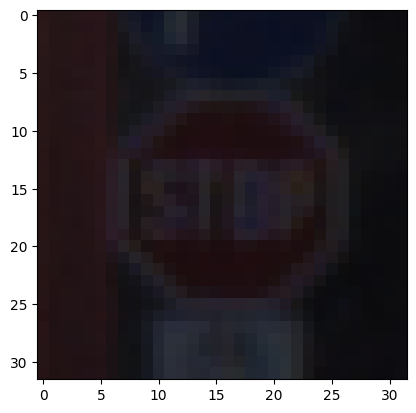

In [4]:
img = cv2.imread('/home/monijesu/Documents/Project/ourData/0/14_29220_1577672016.5557714.png')
plt.imshow(img);

In [5]:
DataGenerator = ImageDataGenerator( horizontal_flip=True,
                                   shear_range=0.2,
                                  rescale= 1./255,
                                  zoom_range=0.2,)
train_dir='/home/monijesu/Documents/Project/ourData'


train_set = DataGenerator.flow_from_directory(
        train_dir,
        target_size=(224,224),
        batch_size=32,
        shuffle = False,
        seed = 42,
        class_mode = "categorical")


Found 2639 images belonging to 4 classes.


In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')
#earlystopping = EarlyStopping(monitor ="val_loss",mode ="min", patience = 6, restore_best_weights = True, verbose=1)

# model check point
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]


mobilenet = MobileNetV2(input_shape=(224,224,3),weights = "imagenet", include_top = False)

for layer in mobilenet.layers:
    layer.trainable = False
    

model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(4,activation='softmax'))
model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_1 (Dense)             (None, 4)                 250884    
                                                                 
Total params: 2,508,868
Trainable params: 250,884
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
mobilenet_hist = model.fit(train_set,epochs=10,callbacks=[es,mc])

Epoch 1/10


2023-03-13 22:47:15.116929: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 154140672 exceeds 10% of free system memory.
2023-03-13 22:47:15.152835: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 156905472 exceeds 10% of free system memory.


 1/83 [..............................] - ETA: 3:50 - loss: 1.3166 - accuracy: 0.4062

2023-03-13 22:47:15.626954: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 154140672 exceeds 10% of free system memory.


83/83 [==============================] - 52s 605ms/step - loss: 7.6094 - accuracy: 0.7696
Epoch 2/10
83/83 [==============================] - 54s 650ms/step - loss: 1.4810 - accuracy: 0.9140
Epoch 3/10
83/83 [==============================] - 56s 667ms/step - loss: 3.6791 - accuracy: 0.8848
Epoch 4/10
83/83 [==============================] - 57s 680ms/step - loss: 4.1669 - accuracy: 0.8844
Epoch 5/10
83/83 [==============================] - 56s 676ms/step - loss: 1.8001 - accuracy: 0.9341
Epoch 6/10
83/83 [==============================] - 58s 691ms/step - loss: 0.7681 - accuracy: 0.9500
Epoch 7/10
83/83 [==============================] - 60s 718ms/step - loss: 0.3332 - accuracy: 0.9757
Epoch 8/10
83/83 [==============================] - 59s 704ms/step - loss: 7.8658 - accuracy: 0.8647
Epoch 9/10
83/83 [==============================] - 57s 687ms/step - loss: 1.1976 - accuracy: 0.9568
Epoch 10/10
83/83 [==============================] - 59s 704ms/step - loss: 0.4049 - accuracy: 0.9773


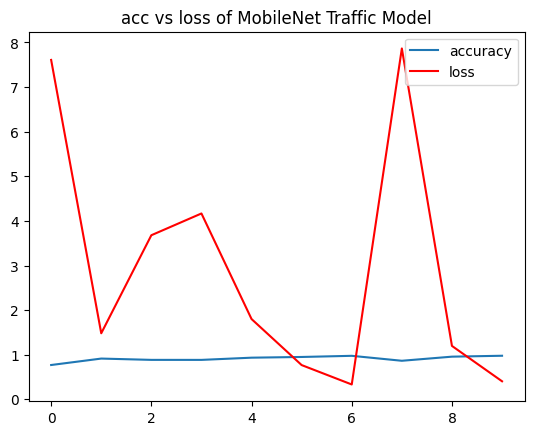

In [10]:
hist = mobilenet_hist.history
plt.plot(hist['accuracy'])
plt.plot(hist['loss'] , c = "red")
plt.legend(['accuracy', 'loss'], loc='upper right')
plt.title("acc vs loss of MobileNet Traffic Model")
plt.show()